In [ ]:
!pip install qutip

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.9/27.9 MB 20.3 MB/s eta 0:00:00


In [ ]:
from qutip import * # * means that we imported all the functions.
import matplotlib.pyplot as plt
import numpy as np
import math
import matplotlib as mpl
from matplotlib import cm
from scipy import special

Now the jump operators, I'll define the basis such that $0\rightarrow |00\rangle$, $1\rightarrow |1-1\rangle$, $2\rightarrow |10\rangle$, $3\rightarrow |11\rangle$

In [ ]:

c=3.0e8
B=3e-4     #magnetic field
v=10
g=1            #landé factor
#hbar=1.05457182e-34
hbar=1
omega0=3e15  #transition frequency between the ground and excited states in the abscence of shifts
Omega=2e7     #interaction strength with the 1->2 laser

Gamma=6.0e7
omegalaser=omega0-3*Gamma
muBohr=9.274e-24
muBohr*=1/1.05457182e-34  #as hbar=1 mubohr
klaser=np.abs(omegalaser*hbar/c)

mu=1.25663706212e-6 #vacum permitivity

redi=1e-8 #time redimensioning constant

I=1000 #coil current
R=0.105  #Coil radius
def CoilBfield(x,y,z,A,R,I): #A is the coordinate of the center of the coil in the y coordinate
  rho=np.sqrt(x**2+y**2)
  k2=4*R*rho/((R+rho)**2+(z-A)**2)
  Bz=0
  Brho=0
  if(np.abs(R-rho)>1e-10 and np.abs(z-A)>1e-10 and rho>0):
    Bz=(mu*I/(2*np.pi))*(special.ellipk(k2)+special.ellipe(k2)*(R**2-rho**2-(z-A)**2)/((R-rho)**2+(z-A)**2))/np.sqrt((R+rho)**2+(z-A)**2)
    Brho=(mu*I/(2*np.pi*rho))*(z-A)*(-special.ellipk(k2)+special.ellipe(k2)*(R**2+rho**2+(z-A)**2)/((R-rho)**2+(z-A)**2))/np.sqrt((R+rho)**2+(z-A)**2)
  if(rho<1e-12):
    Bz=(mu*I/(2*np.pi))*(special.ellipk(k2)+special.ellipe(k2)*(R**2-rho**2-(z-A)**2)/((R-rho)**2+(z-A)**2))/np.sqrt((R+rho)**2+(z-A)**2)
    return 0,0,Bz
  else:
    return (x/rho)*Brho,(y/rho)*Brho,Bz
I00=Qobj([[1,0,0,0],[0,0,0,0],[0,0,0,0],[0,0,0,0]])
I11=Qobj([[0,0,0,0],[0,1,0,0],[0,0,0,0],[0,0,0,0]])
I22=Qobj([[0,0,0,0],[0,0,0,0],[0,0,1,0],[0,0,0,0]])
I33=Qobj([[0,0,0,0],[0,0,0,0],[0,0,0,0],[0,0,0,1]])

I10z=Qobj([[0,0,0,0],[1,0,0,0],[0,0,0,0],[0,0,0,0]])   #|1-1><00|
I20z=Qobj([[0,0,0,0],[0,0,0,0],[1,0,0,0],[0,0,0,0]])
I30z=Qobj([[0,0,0,0],[0,0,0,0],[0,0,0,0],[1,0,0,0]])
I01z=I10z.dag()
I02z=I20z.dag()
I03z=I30z.dag()

I10x=Qobj([[0,0,0,0],[1/2,0,0,0],[-1/np.sqrt(2),0,0,0],[1/2,0,0,0]])
I20x=Qobj([[0,0,0,0],[1/np.sqrt(2),0,0,0],[0,0,0,0],[-1/np.sqrt(2),0,0,0]])
I30x=Qobj([[0,0,0,0],[1/2,0,0,0],[1/np.sqrt(2),0,0,0],[1/2,0,0,0]])
I01x=I10x.dag()
I02x=I20x.dag()
I03x=I30x.dag()

I10y=Qobj([[0,0,0,0],[-1/2,0,0,0],[-1j/np.sqrt(2),0,0,0],[1/2,0,0,0]])
I20y=Qobj([[0,0,0,0],[1j/np.sqrt(2),0,0,0],[0,0,0,0],[1j/np.sqrt(2),0,0,0]])       #D(pi/2,pi/2,pi/2)
I30y=Qobj([[0,0,0,0],[1/2,0,0,0],[-1j/np.sqrt(2),0,0,0],[-1/2,0,0,0]])
I01y=I10y.dag()
I02y=I20y.dag()
I03y=I30y.dag()




Decay01=Qobj([[0,np.sqrt(Gamma*redi),0,0],[0,0,0,0],[0,0,0,0],[0,0,0,0]])
Decay03=Qobj([[0,0,0,np.sqrt(Gamma*redi)],[0,0,0,0],[0,0,0,0],[0,0,0,0]])
Decay02=Qobj([[0,0,np.sqrt(Gamma*redi),0],[0,0,0,0],[0,0,0,0],[0,0,0,0]])

In [ ]:
def Coeff01z(t,args):
  return Omega*redi*np.exp(1j*(args["omegalaser1z"]*redi)*t)*np.exp(1j*args["propagationz"]*(omegalaser/c)*args["z"])
def Coeff10z(t,args):
  return Omega*redi*np.exp(-1j*(args["omegalaser1z"]*redi)*t)*np.conj(np.exp(1j*args["propagationz"]*(omegalaser/c)*args["z"]))
def Coeff03z(t,args):
  return Omega*redi*np.exp(1j*(args["omegalaser3z"]*redi)*t)*np.exp(-1j*args["propagationz"]*(omegalaser/c)*args["z"])
def Coeff30z(t,args):
  return Omega*redi*np.exp(-1j*(args["omegalaser3z"]*redi)*t)*np.conj(np.exp(-1j*args["propagationz"]*(omegalaser/c)*args["z"]))

def Coeff01x(t,args):
  return Omega*redi*np.exp(1j*(args["omegalaser1x"]*redi)*t)*np.exp(1j*args["propagationx"]*(omegalaser/c)*args["x"])
def Coeff10x(t,args):
  return Omega*redi*np.exp(-1j*(args["omegalaser1x"]*redi)*t)*np.conj(np.exp(1j*args["propagationx"]*(omegalaser/c)*args["x"]))
def Coeff03x(t,args):
  return Omega*redi*np.exp(1j*(args["omegalaser3x"]*redi)*t)*np.exp(-1j*args["propagationx"]*(omegalaser/c)*args["x"])
def Coeff30x(t,args):
  return Omega*redi*np.exp(-1j*(args["omegalaser3x"]*redi)*t)*np.conj(np.exp(-1j*args["propagationx"]*(omegalaser/c)*args["x"]))

def Coeff01y(t,args):
  return Omega*redi*np.exp(1j*(args["omegalaser1y"]*redi)*t)*np.exp(1j*args["propagationy"]*(omegalaser/c)*args["y"])
def Coeff10y(t,args):
  return Omega*redi*np.exp(-1j*(args["omegalaser1y"]*redi)*t)*np.conj(np.exp(1j*args["propagationy"]*(omegalaser/c)*args["y"]))
def Coeff03y(t,args):
  return Omega*redi*np.exp(1j*(args["omegalaser3y"]*redi)*t)*np.exp(-1j*args["propagationy"]*(omegalaser/c)*args["y"])
def Coeff30y(t,args):
  return Omega*redi*np.exp(-1j*(args["omegalaser3y"]*redi)*t)*np.conj(np.exp(-1j*args["propagationy"]*(omegalaser/c)*args["y"]))


In [ ]:
def EdipoleForce1Dz(t,args): #this is the dipole Hamiltonian of a set of a pair of lasers in one dimension, laser 1 is the one driving the 0->1 transition
  k=np.abs(omegalaser*hbar/c)
  F=-args["propagationz"]*(-1j*k*I10z*Coeff10z(t,args) \
                  +1j*k*I01z*Coeff01z(t,args) \
                  +1j*k*I30z*Coeff30z(t,args) \
                  -1j*k*I03z*Coeff03z(t,args))
  return F

def EdipoleForce1Dx(t,args): #this is the dipole Hamiltonian of a set of a pair of lasers in one dimension, laser 1 is the one driving the 0->1 transition
  k=np.abs(omegalaser*hbar/c)
  F=-args["propagationx"]*(-1j*k*I10x*Coeff10x(t,args) \
                  +1j*k*I01x*Coeff01x(t,args) \
                  +1j*k*I30x*Coeff30x(t,args) \
                  -1j*k*I03x*Coeff03x(t,args))
  return F

def EdipoleForce1Dy(t,args): #this is the dipole Hamiltonian of a set of a pair of lasers in one dimension, laser 1 is the one driving the 0->1 transition
  k=np.abs(omegalaser*hbar/c)
  F=-args["propagationy"]*(-1j*k*I10y*Coeff10y(t,args) \
                  +1j*k*I01y*Coeff01y(t,args) \
                  +1j*k*I30y*Coeff30y(t,args) \
                  -1j*k*I03y*Coeff03y(t,args))
  return F

def Zeeman1Dz(B): #this includes the zeeman whift to the energy levels
  Zeem=-redi*g*B*muBohr*I10z*I01z+redi*g*B*muBohr*I30z*I03z
  return Zeem

def Zeeman1Dx(B): #this includes the zeeman whift to the energy levels
  Zeem=-redi*g*B*muBohr*I10x*I01x+redi*g*B*muBohr*I30x*I03x
  return Zeem

def Zeeman1Dy(B): #this includes the zeeman whift to the energy levels
  Zeem=-redi*g*B*muBohr*I10y*I01y+redi*g*B*muBohr*I30y*I03y
  return Zeem


def Zeeman3D(args):
  Zz=Zeeman1Dz(args["Bz"])

  Zx=Zeeman1Dx(args["Bx"])

  Zy=Zeeman1Dy(args["By"])

  Z=Zz+Zy+Zx
  return Z

NH=1
omegar=Gamma/NH
Tau=2*np.pi/(omegar*redi)
class Atom:
  def __init__(self,x0,y0,z0,Vx0,Vy0,Vz0,m0,Fx0,Fy0,Fz0,rho0: Qobj):
      self.rho=rho0
      self.m=m0
      self.r=np.array([x0,y0,z0])
      self.V=np.array([Vx0,Vy0,Vz0])
      self.F=np.array([Fx0,Fy0,Fz0])
  def BorreFuerza(self):
    self.F=np.array([0,0,0])
  def Muevase(self,dt):
    self.V=self.V+dt*(self.F*1e-34/self.m) ##where we include the planck constant, so the acceleration has magnitude of 10^6 or 10^5 or something similar
    self.r=self.r+dt*self.V
  def Calculaterho(self,tin,tfin,timesteps):
    times = np.linspace(tin, tfin, timesteps)

    B1,B2,B3=CoilBfield(self.r[0],self.r[1],self.r[2],R/2,R,I)
    B11,B22,B33=CoilBfield(self.r[0],self.r[1],self.r[2],-R/2,R,-I)
    Bx=B11+B1
    By=B22+B2
    Bz=B33+B3

    argsrho = {
        "x": self.r[0],
        "y": self.r[1],
        "z": self.r[2],
        "Bx": Bx,
        "By": By,
        "Bz": Bz,
        "omegalaser1x": 0,
        "omegalaser3x": 0,
        "omegalaser1y": 0,
        "omegalaser3y": 0,
        "omegalaser1z": 0,
        "omegalaser3z": 0,
        "propagationx": -1,
        "propagationy": -1,
        "propagationz": 1
    }
    argsrho["omegalaser1z"]=-3*Gamma+self.V[2]*omegalaser/c #Deltalaser=omegalaser-omega0
    argsrho["omegalaser3z"]=-3*Gamma-self.V[2]*omegalaser/c
    argsrho["omegalaser1y"]=-3*Gamma-self.V[1]*omegalaser/c #Deltalaser=omegalaser-omega0
    argsrho["omegalaser3y"]=-3*Gamma+self.V[1]*omegalaser/c
    argsrho["omegalaser1x"]=-3*Gamma-self.V[0]*omegalaser/c #Deltalaser=omegalaser-omega0
    argsrho["omegalaser3x"]=-3*Gamma+self.V[0]*omegalaser/c

    Zeem=Zeeman3D(argsrho)

    Hamil=[Zeem,[I10z,Coeff10z],[I01z,Coeff01z],[I30z,Coeff30z],[I03z,Coeff03z],
                [I10y,Coeff10y],[I01y,Coeff01y],[I30y,Coeff30y],[I03y,Coeff03y],
                [I10x,Coeff10x],[I01x,Coeff01x],[I30x,Coeff30x],[I03x,Coeff03x]]

    resultrho = mesolve(Hamil, self.rho, times, [Decay01,Decay02,Decay03],args=argsrho)
    self.rho = resultrho.states[timesteps-1]

    return resultrho
  def CalculateForce(self,tin,tfinal,timesteps):
    times = np.linspace(tin, tfinal, timesteps)

    B1,B2,B3=CoilBfield(self.r[0],self.r[1],self.r[2],R/2,R,I)
    B11,B22,B33=CoilBfield(self.r[0],self.r[1],self.r[2],-R/2,R,-I)
    Bx=B11+B1
    By=B22+B2
    Bz=B33+B3

    argsForce = {
        "x": self.r[0],
        "y": self.r[1],
        "z": self.r[2],
        "Bx": Bx,
        "By": By,
        "Bz": Bz,
        "omegalaser1x": 0,
        "omegalaser3x": 0,
        "omegalaser1y": 0,
        "omegalaser3y": 0,
        "omegalaser1z": 0,
        "omegalaser3z": 0,
        "propagationx": -1,
        "propagationy": -1,
        "propagationz": 1
    }
    argsForce["omegalaser1z"]=-3*Gamma+self.V[2]*omegalaser/c #Deltalaser=omegalaser-omega0
    argsForce["omegalaser3z"]=-3*Gamma-self.V[2]*omegalaser/c
    argsForce["omegalaser1y"]=-3*Gamma-self.V[1]*omegalaser/c #Deltalaser=omegalaser-omega0
    argsForce["omegalaser3y"]=-3*Gamma+self.V[1]*omegalaser/c
    argsForce["omegalaser1x"]=-3*Gamma-self.V[0]*omegalaser/c #Deltalaser=omegalaser-omega0
    argsForce["omegalaser3x"]=-3*Gamma+self.V[0]*omegalaser/c


    Zeem=Zeeman3D(argsForce)
    Hamil=[Zeem,[I10z,Coeff10z],[I01z,Coeff01z],[I30z,Coeff30z],[I03z,Coeff03z],
                [I10y,Coeff10y],[I01y,Coeff01y],[I30y,Coeff30y],[I03y,Coeff03y],
                [I10x,Coeff10x],[I01x,Coeff01x],[I30x,Coeff30x],[I03x,Coeff03x]]

    Fx=EdipoleForce1Dx(tfinal,argsForce)
    Fy=EdipoleForce1Dy(tfinal,argsForce)
    Fz=EdipoleForce1Dz(tfinal,argsForce)

    resultForce = mesolve(Hamil, self.rho, times, [Decay01,Decay02,Decay03],[Fx,Fy,Fz],args=argsForce)

    return resultForce

  def CalculateAveragedForce(self,tsteady,xavgsteps,tavgsteps):
    argsf = {
        "x": self.r[0],
        "y": self.r[1],
        "z": self.r[2],
        "omegalaser1x": 0,
        "omegalaser3x": 0,
        "omegalaser1y": 0,
        "omegalaser3y": 0,
        "omegalaser1z": 0,
        "omegalaser3z": 0,
        "propagationx": -1,
        "propagationy": -1,
        "propagationz": 1
    }
    argsf["omegalaser1z"]=-3*Gamma+self.V[2]*omegalaser/c #Deltalaser=omegalaser-omega0
    argsf["omegalaser3z"]=-3*Gamma-self.V[2]*omegalaser/c
    argsf["omegalaser1y"]=-3*Gamma-self.V[1]*omegalaser/c #Deltalaser=omegalaser-omega0
    argsf["omegalaser3y"]=-3*Gamma+self.V[1]*omegalaser/c
    argsf["omegalaser1x"]=-3*Gamma-self.V[0]*omegalaser/c #Deltalaser=omegalaser-omega0
    argsf["omegalaser3x"]=-3*Gamma+self.V[0]*omegalaser/c
    Fx=0
    Fy=0
    Fz=0
    x0=self.r[0]
    y0=self.r[1]
    z0=self.r[2]
    for z in np.linspace(z0,z0+2*np.pi/klaser,xavgsteps):
      for y in np.linspace(y0,y0+2*np.pi/klaser,xavgsteps):
        for x in np.linspace(x0,x0+2*np.pi/klaser,xavgsteps):
          self.rho=I00
          argsf["x"]=x
          argsf["y"]=y
          argsf["z"]=z

          self.r=np.array([x,y,z])
          self.Calculaterho(0,tsteady,2)
          resultrhoavg = self.Calculaterho(tsteady,tsteady+Tau,tavgsteps) ## wr---> tau=2pi/wr, wr=Gamma, vk=Gamma, detunning=3Gamma ---> periodico con frecuencia gamma

          ii=0
          for t in np.linspace(tsteady,tsteady+Tau,tavgsteps):
            Opx=EdipoleForce1Dx(t,argsf)*resultrhoavg.states[ii]
            Opy=EdipoleForce1Dy(t,argsf)*resultrhoavg.states[ii]
            Opz=EdipoleForce1Dz(t,argsf)*resultrhoavg.states[ii]
            Fx+=Opx.tr()/(tavgsteps*xavgsteps**3)
            Fy+=Opy.tr()/(tavgsteps*xavgsteps**3)
            Fz+=Opz.tr()/(tavgsteps*xavgsteps**3)

            ii+=1
    timesteps=30

    return Fx,Fy,Fz

In [ ]:
Sodio7=Atom(0,0,0,0,0,0,3.817e-26,0,0,0,rho0=Qobj([[1,0,0,0],[0,0,0,0],[0,0,0,0],[0,0,0,0]]))
args = {
    "x": Sodio7.r[0],
    "y": Sodio7.r[1],
    "z": Sodio7.r[2],
    "omegalaser1x": 0,
    "omegalaser3x": 0,
    "omegalaser1y": 0,
    "omegalaser3y": 0,
    "omegalaser1z": 0,
    "omegalaser3z": 0,
    "propagationx": -1,
    "propagationy": -1,
    "propagationz": 1
}
args["omegalaser1z"]=-3*Gamma+Sodio7.V[2]*omegalaser/c #Deltalaser=omegalaser-omega0
args["omegalaser3z"]=-3*Gamma-Sodio7.V[2]*omegalaser/c
args["omegalaser1y"]=-3*Gamma-Sodio7.V[1]*omegalaser/c #Deltalaser=omegalaser-omega0
args["omegalaser3y"]=-3*Gamma+Sodio7.V[1]*omegalaser/c
args["omegalaser1x"]=-3*Gamma-Sodio7.V[0]*omegalaser/c #Deltalaser=omegalaser-omega0
args["omegalaser3x"]=-3*Gamma+Sodio7.V[0]*omegalaser/c
Fxx=0
Fyy=0
Fzz=0
tsteady=30
tavgsteps=2
xavgsteps=10
x0=Sodio7.r[0]
y0=Sodio7.r[1]
z0=Sodio7.r[2]

for x in np.linspace(x0,x0+2*np.pi/klaser,xavgsteps):
  for y in np.linspace(y0,y0+2*np.pi/klaser,xavgsteps):
    for z in np.linspace(z0,z0+2*np.pi/klaser,xavgsteps):
      Sodio7.rho=I00
      Sodio7.r=np.array([x,y,z])
      Sodio7.Calculaterho(0,tsteady,2)
      resultrhoavg = Sodio7.Calculaterho(tsteady,tsteady+Tau,tavgsteps)
      ii=0
      args["x"]=Sodio7.r[0]
      args["y"]=Sodio7.r[1]
      args["z"]=Sodio7.r[2]
      for t in np.linspace(tsteady,tsteady+Tau,tavgsteps):
        Opx=EdipoleForce1Dx(t,args)*resultrhoavg.states[ii]
        Opy=EdipoleForce1Dy(t,args)*resultrhoavg.states[ii]
        Opz=EdipoleForce1Dz(t,args)*resultrhoavg.states[ii]
        #print(Opz.tr())
        #print(Opx.tr().real,Opy.tr().real,Opz.tr().real)
        Fxx+=Opx.tr()/(xavgsteps**3*tavgsteps)
        Fyy+=Opy.tr()/(xavgsteps**3*tavgsteps)
        Fzz+=Opz.tr()/(xavgsteps**3*tavgsteps)
        ii+=1
print(Fxx,Fyy,Fzz)

(7523.018383884017+3.880438637834977e-09j) (-1.5742604133490954+1.0839412425411834e-09j) (-3.041992804457298+9.938439688994507e-10j)


/usr/local/lib/python3.10/dist-packages/matplotlib/cbook/__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


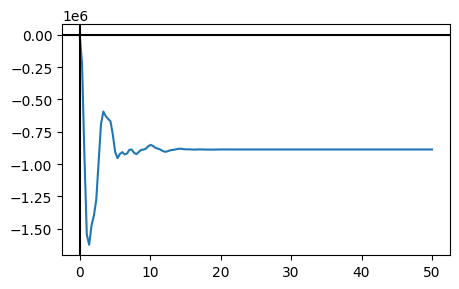

In [ ]:
Sodio=Atom(0.04,0.01,0.02,0,0,0,3.817e-26,0,0,0,rho0=Qobj([[1,0,0,0],[0,0,0,0],[0,0,0,0],[0,0,0,0]]))
args = {
    "x": Sodio.r[0],
    "y": Sodio.r[1],
    "z": Sodio.r[2],
    "omegalaser1x": 0,
    "omegalaser3x": 0,
    "omegalaser1y": 0,
    "omegalaser3y": 0,
    "omegalaser1z": 0,
    "omegalaser3z": 0,
    "propagationx": -1,
    "propagationy": -1,
    "propagationz": 1
}

args["omegalaser1z"]=-3*Gamma+Sodio.V[2]*omegalaser/c #Deltalaser=omegalaser-omega0
args["omegalaser3z"]=-3*Gamma-Sodio.V[2]*omegalaser/c
args["omegalaser1y"]=-3*Gamma-Sodio.V[1]*omegalaser/c #Deltalaser=omegalaser-omega0
args["omegalaser3y"]=-3*Gamma+Sodio.V[1]*omegalaser/c
args["omegalaser1x"]=-3*Gamma-Sodio.V[0]*omegalaser/c #Deltalaser=omegalaser-omega0
args["omegalaser3x"]=-3*Gamma+Sodio.V[0]*omegalaser/c

tmax=50
timesteps=150

times = np.linspace(0.0, tmax, timesteps)

resultrho= Sodio.Calculaterho(0,tmax,timesteps)

resultForce= Sodio.CalculateForce(0,tmax,timesteps)
Ftrange = np.linspace(0,tmax,timesteps,dtype=complex)

kk=0
for t in times:
  Op=EdipoleForce1Dx(t,args)*resultrho.states[kk]
  Ftrange[kk]=Op.tr()
  kk+=1
plt.rcParams["figure.figsize"] = (5,3)
plt.plot(times,Ftrange)
#plt.plot(times,resultForce.expect[0])
plt.axhline(0, color='black')
plt.axvline(0, color='black')


/usr/local/lib/python3.10/dist-packages/matplotlib/cbook/__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


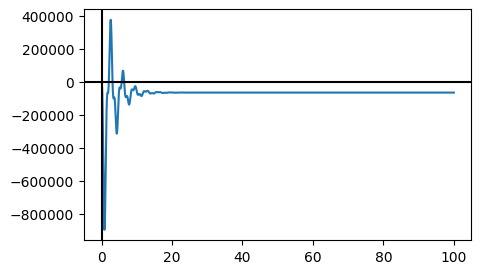

In [ ]:
#now I want to see the force as a function of the magnetic field
vv=0
Sodio3=Atom(0.0,0.0,0.06,0,0,0,3.817e-26,0,0,0,rho0=Qobj([[1,0,0,0],[0,0,0,0],[0,0,0,0],[0,0,0,0]]))
args = {
    "x": Sodio3.r[0],
    "y": Sodio3.r[1],
    "z": Sodio3.r[2],
    "omegalaser1x": 0,
    "omegalaser3x": 0,
    "omegalaser1y": 0,
    "omegalaser3y": 0,
    "omegalaser1z": 0,
    "omegalaser3z": 0,
    "propagationx": -1,
    "propagationy": -1,
    "propagationz": 1
}

args["omegalaser1z"]=-3*Gamma+Sodio3.V[2]*omegalaser/c #Deltalaser=omegalaser-omega0
args["omegalaser3z"]=-3*Gamma-Sodio3.V[2]*omegalaser/c
args["omegalaser1y"]=-3*Gamma-Sodio3.V[1]*omegalaser/c #Deltalaser=omegalaser-omega0
args["omegalaser3y"]=-3*Gamma+Sodio3.V[1]*omegalaser/c
args["omegalaser1x"]=-3*Gamma-Sodio3.V[0]*omegalaser/c #Deltalaser=omegalaser-omega0
args["omegalaser3x"]=-3*Gamma+Sodio3.V[0]*omegalaser/c

tmax=100

timesteps=1000

times = np.linspace(0.0, tmax, timesteps)

resultrho3 = Sodio3.Calculaterho(0,tmax,timesteps)

Ftrange = np.linspace(0,tmax,timesteps,dtype=complex)

kk=0
for t in times:
  Op=EdipoleForce1Dy(t,args)*resultrho3.states[kk]
  Ftrange[kk]=Op.tr()
  kk+=1
plt.plot(times,Ftrange)
plt.axhline(0, color='black')
plt.axvline(0, color='black')

In [ ]:
print(2*np.pi/klaser)

6.283185684170727e-07


-0.05 83022.3650682552
-0.04772727272727273 90202.18777358928
-0.045454545454545456 104448.72513087938
-0.04318181818181818 123540.2079800992
-0.04090909090909091 145273.51713655662
-0.038636363636363635 171592.78651030498
-0.03636363636363636 204969.010772282
-0.03409090909090909 252296.36595478316
-0.031818181818181815 328249.5178568371
-0.029545454545454545 438441.97898247145
-0.02727272727272727 577646.9951537094
-0.024999999999999998 720222.5898739098
-0.022727272727272728 769974.4355190909
-0.020454545454545454 689701.407811565
-0.01818181818181818 536561.3464761467
-0.015909090909090907 380078.7100632357
-0.013636363636363634 259674.24585321094
-0.01136363636363636 172768.2098181617
-0.009090909090909087 117990.35146861163
-0.0068181818181818135 84758.06540430867
-0.00454545454545454 59838.78276385975
-0.0022727272727272665 32892.52595689965
6.938893903907228e-18 4195.35564532346
0.0022727272727272804 -24426.51946175753
0.004545454545454547 -51208.94820743068
0.00681818181818182

/usr/local/lib/python3.10/dist-packages/matplotlib/cbook/__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


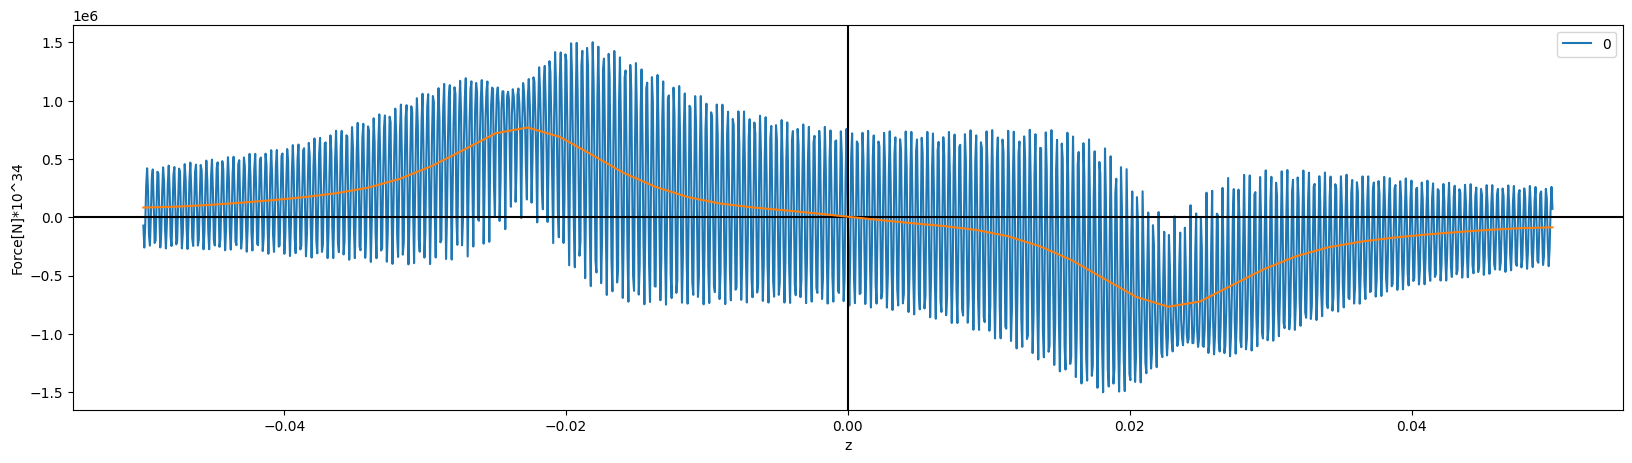

In [ ]:
#now I want to see the force as a function of the magnetic field
Sodio3=Atom(0,0,0,0,0,0,3.817e-26,0,0,0,rho0=Qobj([[1,0,0,0],[0,0,0,0],[0,0,0,0],[0,0,0,0]]))
plt.rcParams["figure.figsize"] = (20,5)
plt.xlabel("z")
plt.ylabel("Force[N]*10^34")
tmax=15
timesteps=2
vrange=np.linspace(-0,0,1)
for v in vrange:
  xsteps=1500
  xdata=np.linspace(-5e-2,5e-2,xsteps)
  Frange= np.zeros(xsteps)
  ii=0
  k=0

  args["omegalaser1z"]=-3*Gamma+v*omegalaser/c #Deltalaser=omegalaser-omega0
  args["omegalaser3z"]=-3*Gamma-v*omegalaser/c
  ii=0
  for z in xdata:
    Sodio3.r=np.array([Sodio3.r[0],Sodio3.r[1],z])
    resultForce = Sodio3.CalculateForce(0,tmax,timesteps)
    Frange[ii]=resultForce.expect[2][timesteps-1]
    ii+=1
  plt.plot(xdata, Frange)

plt.legend(["0", "1", "2"])
plt.axhline(0, color='black')
plt.axvline(0, color='black')

Sodio5=Atom(0,0,0,0,0,0,3.817e-26,0,0,0,rho0=Qobj([[1,0,0,0],[0,0,0,0],[0,0,0,0],[0,0,0,0]]))

plt.rcParams["figure.figsize"] = (20,5)
plt.xlabel("z")
plt.ylabel("Force[N]*10^34")
vrange=np.linspace(-0,0,1)
for v in vrange:
  xsteps=45
  xdata=np.linspace(-5e-2,5e-2,xsteps)
  Frange= np.linspace(0,0,xsteps,dtype=complex)
  ii=0
  k=0

  args["omegalaser1z"]=-3*Gamma+v*omegalaser/c #Deltalaser=omegalaser-omega0
  args["omegalaser3z"]=-3*Gamma-v*omegalaser/c

  for z in xdata:
    Sodio5.r=np.array([Sodio5.r[0],Sodio5.r[1],z])
    erase1,erase2,Fz = Sodio5.CalculateAveragedForce(tmax,10,2)
    Frange[ii]=Fz.real
    print(z,Fz.real)
    ii+=1
  plt.plot(xdata, Frange)

-0.05 306992.20590091293
-0.04772727272727273 407234.3209743776
-0.045454545454545456 535839.8230783581
-0.04318181818181818 679356.9266013778
-0.04090909090909091 793672.0272542656
-0.038636363636363635 822660.6012939857
-0.03636363636363636 750466.4215540126
-0.03409090909090909 623987.8486231597
-0.031818181818181815 497690.09163244604
-0.029545454545454545 392391.39995466033
-0.02727272727272727 309598.32409809326
-0.024999999999999998 246212.68368773977
-0.022727272727272728 197253.26302712594
-0.020454545454545454 158936.95527428237
-0.01818181818181818 128435.508720529
-0.015909090909090907 103422.37218388669
-0.013636363636363634 82529.79164631851
-0.01136363636363636 64747.16288820234
-0.009090909090909087 49193.67482475797
-0.0068181818181818135 35312.358675165124
-0.00454545454545454 22713.11081128433
-0.0022727272727272665 11062.391269492373
6.938893903907228e-18 -4.775136673964822
0.0022727272727272804 -11069.92118745228
0.004545454545454547 -22715.3047143583
0.00681818181

/usr/local/lib/python3.10/dist-packages/matplotlib/cbook/__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


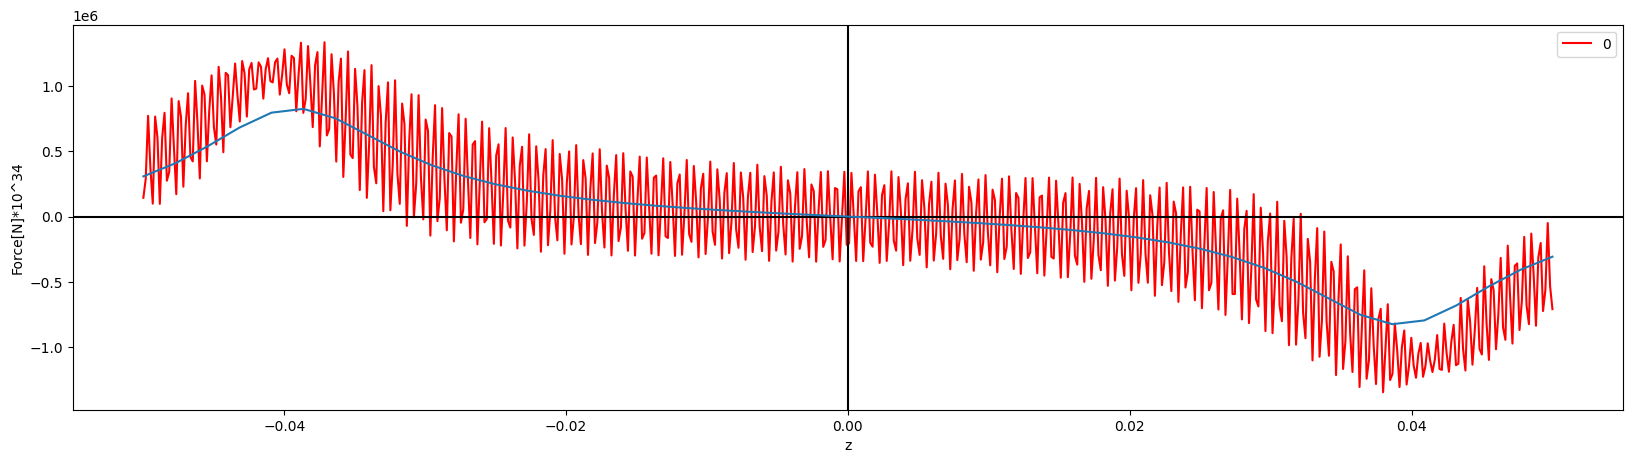

In [ ]:
#now I want to see the force as a function of the magnetic field
Sodio3=Atom(0,0,0.00001,0,0,0,3.817e-26,0,0,0,rho0=Qobj([[1,0,0,0],[0,0,0,0],[0,0,0,0],[0,0,0,0]]))
tmax=15
timesteps=2
plt.rcParams["figure.figsize"] = (20,5)
plt.xlabel("y")
plt.ylabel("Force[N]*10^34")
vrange=np.linspace(-0,0,1)
for v in vrange:
  xsteps=600
  xdata=np.linspace(-5e-2,5e-2,xsteps)
  Frange= np.zeros(xsteps)
  ii=0
  k=0

  Sodio3.V=np.array([Sodio3.V[0],v,Sodio3.V[2]])
  Sodio3.V=np.array([Sodio3.V[0],v,Sodio3.V[2]])
  ii=0
  for y in xdata:
    Sodio3.r=np.array([Sodio3.r[0],y,Sodio3.r[2]])
    resultForce = Sodio3.CalculateForce(0,tmax,timesteps)
    Frange[ii]=resultForce.expect[1][timesteps-1]
    ii+=1
  plt.plot(xdata, Frange, color="red")

plt.legend(["0", "1", "2"])
plt.axhline(0, color='black')
plt.axvline(0, color='black')

Sodio3=Atom(0,0,0,0,0,0,3.817e-26,0,0,0,rho0=Qobj([[1,0,0,0],[0,0,0,0],[0,0,0,0],[0,0,0,0]]))

plt.rcParams["figure.figsize"] = (20,5)
plt.xlabel("z")
plt.ylabel("Force[N]*10^34")
vrange=np.linspace(-0,0,1)
for v in vrange:
  xsteps=45
  xdata=np.linspace(-5e-2,5e-2,xsteps)
  Frange= np.linspace(0,0,xsteps,dtype=complex)
  ii=0

  args["omegalaser1x"]=-3*Gamma-v*omegalaser/c #Deltalaser=omegalaser-omega0
  args["omegalaser3x"]=-3*Gamma+v*omegalaser/c

  for y in xdata:
    Sodio3.r=np.array([Sodio3.r[0],y,Sodio3.r[2]])
    erase2,Fy,erase1 = Sodio3.CalculateAveragedForce(tmax,9,7)
    Frange[ii]=Fy.real
    print(y,Fy.real)
    ii+=1
  plt.plot(xdata, Frange)

-0.05 290966.299117504
-0.04772727272727273 368745.7494947207
-0.045454545454545456 478656.50249263947
-0.04318181818181818 610739.0998210359
-0.04090909090909091 713423.1634584651
-0.038636363636363635 729913.7762846161
-0.03636363636363636 661323.1332391506
-0.03409090909090909 562159.9510539823
-0.031818181818181815 473865.3181874427
-0.029545454545454545 387525.3984325798
-0.02727272727272727 301718.27105795895
-0.024999999999999998 227131.82746909012
-0.022727272727272728 175340.3160875722
-0.020454545454545454 148144.6753960045
-0.01818181818181818 134070.88235733064
-0.015909090909090907 115901.86909131621
-0.013636363636363634 88140.49168723014
-0.01136363636363636 57341.60705105589
-0.009090909090909087 34862.099209447384
-0.0068181818181818135 26463.562439426572
-0.00454545454545454 26964.025152974413
-0.0022727272727272665 23792.90937390683
6.938893903907228e-18 9280.171386216603
0.0022727272727272804 -13657.282718296938
0.004545454545454547 -34800.79612541933
0.006818181818

/usr/local/lib/python3.10/dist-packages/matplotlib/cbook/__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


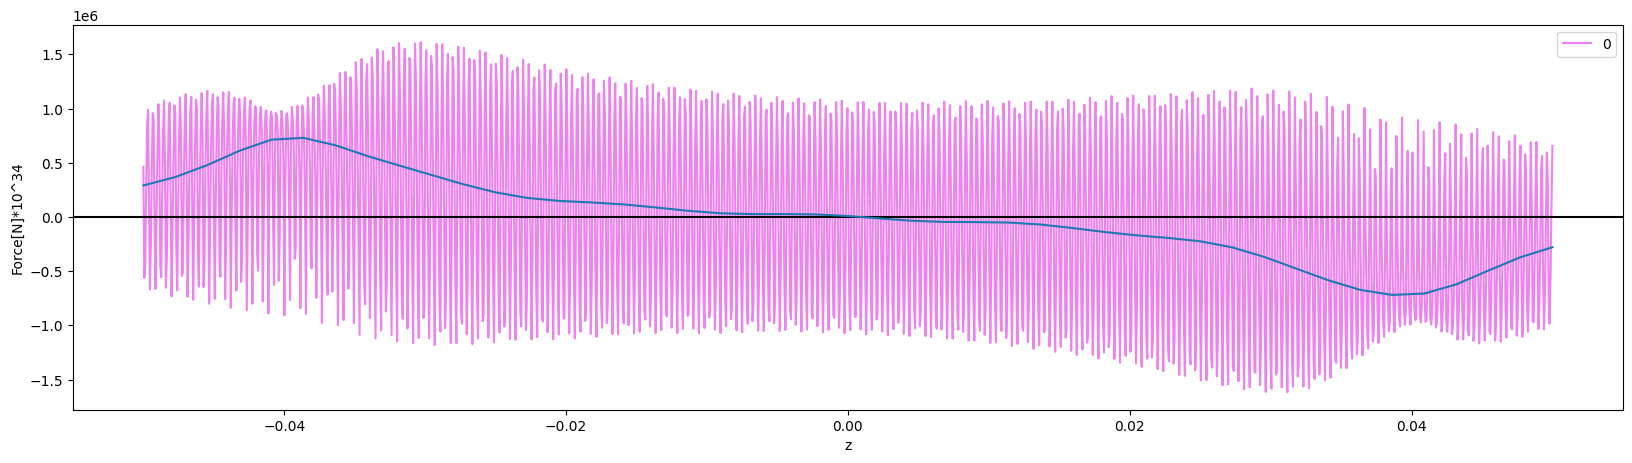

In [ ]:
#now I want to see the force as a function of the magnetic field
Sodio3=Atom(0,0,0,0,0,0,3.817e-26,0,0,0,rho0=Qobj([[1,0,0,0],[0,0,0,0],[0,0,0,0],[0,0,0,0]]))
tmax=15
timesteps=2
plt.rcParams["figure.figsize"] = (20,5)
plt.xlabel("x")
plt.ylabel("Force[N]*10^34")
vrange=np.linspace(-0,0,1)
for v in vrange:
  xsteps=1500
  xdata=np.linspace(-5e-2,5e-2,xsteps)
  Frange= np.zeros(xsteps)
  k=0

  args["omegalaser1z"]=-3*Gamma+v*omegalaser/c #Deltalaser=omegalaser-omega0
  args["omegalaser3z"]=-3*Gamma-v*omegalaser/c
  ii=0
  for x in xdata:
    Sodio3.r=np.array([x,Sodio3.r[1],Sodio3.r[2]])
    resultForce = Sodio3.CalculateForce(0,tmax,timesteps)
    Frange[ii]=resultForce.expect[0][timesteps-1]
    ii+=1
  plt.plot(xdata, Frange, color="violet")

plt.legend(["0", "1", "2"])
plt.axhline(0, color='black')
#plt.axvline(0, color='black')
Sodio3=Atom(0,0,0,0,0,0,3.817e-26,0,0,0,rho0=Qobj([[1,0,0,0],[0,0,0,0],[0,0,0,0],[0,0,0,0]]))

plt.rcParams["figure.figsize"] = (20,5)
plt.xlabel("z")
plt.ylabel("Force[N]*10^34")
vrange=np.linspace(-0,0,1)
for v in vrange:
  xsteps=45
  xdata=np.linspace(-5e-2,5e-2,xsteps)
  Frange= np.linspace(0,0,xsteps,dtype=complex)
  ii=0

  args["omegalaser1x"]=-3*Gamma-v*omegalaser/c #Deltalaser=omegalaser-omega0
  args["omegalaser3x"]=-3*Gamma+v*omegalaser/c

  for x in xdata:
    Sodio3.r=np.array([x,Sodio3.r[1],Sodio3.r[2]])
    Fx,erase2,erase1 = Sodio3.CalculateAveragedForce(tmax,9,7)
    Frange[ii]=Fx.real
    print(x,Fx.real)
    ii+=1
  plt.plot(xdata, Frange)

/usr/local/lib/python3.10/dist-packages/matplotlib/cbook/__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


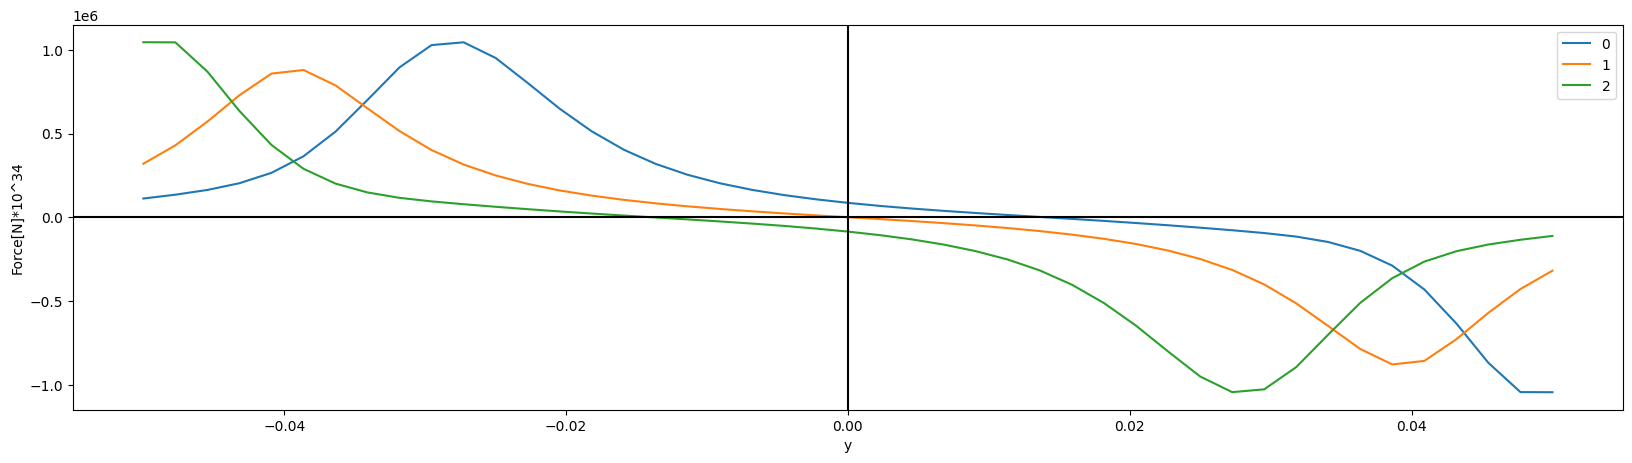

In [ ]:
v0=Gamma/klaser

Sodio3=Atom(0,0,0,0,0,0,3.817e-26,0,0,0,rho0=Qobj([[1,0,0,0],[0,0,0,0],[0,0,0,0],[0,0,0,0]]))
tmax=15

plt.rcParams["figure.figsize"] = (20,5)
plt.xlabel("y")
plt.ylabel("Force[N]*10^34")
vrange=np.linspace(-v0,v0,3)
for v in vrange:
  Sodio3.V=np.array([0,v,0])
  xsteps=45
  xdata=np.linspace(-5e-2,5e-2,xsteps)
  Frange= np.linspace(0,0,xsteps,dtype=complex)
  ii=0
  for y in xdata:
    Sodio3.r=np.array([Sodio3.r[0],y,Sodio3.r[2]])
    erase2,Fy,erase1 = Sodio3.CalculateAveragedForce(tmax,5,12)
    Frange[ii]=Fy.real
    ii+=1
  plt.plot(xdata, Frange)
plt.legend(["0", "1", "2"])
plt.axhline(0, color='black')
plt.axvline(0, color='black')

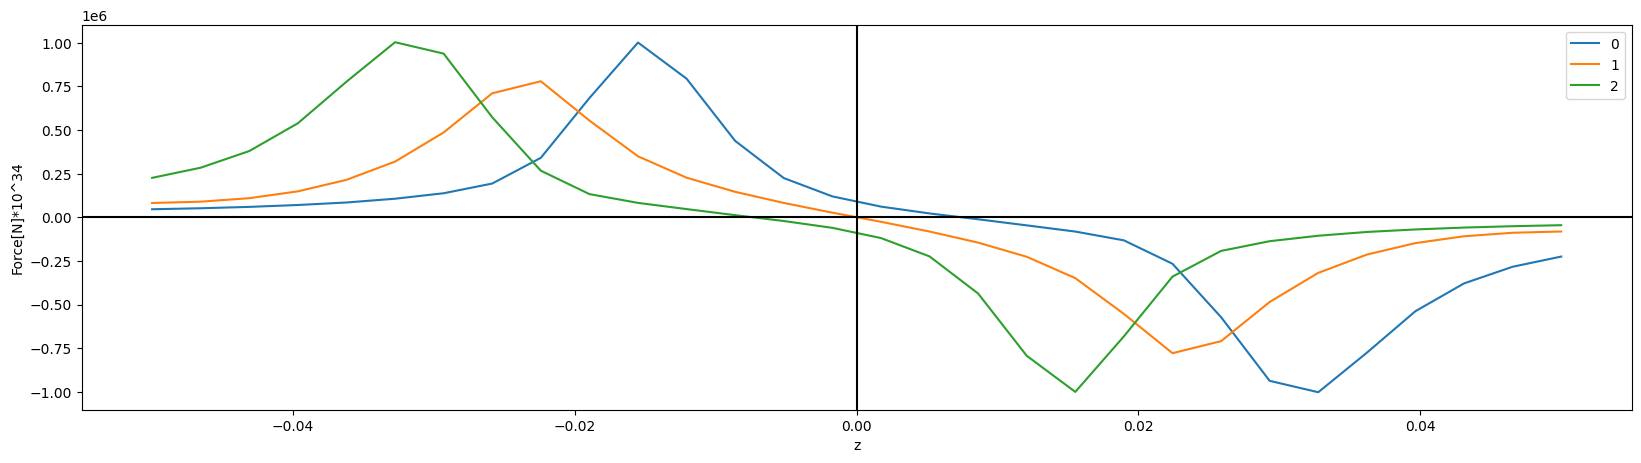

In [ ]:
v0=Gamma/klaser
Sodio5=Atom(0,0,0,0,0,0,3.817e-26,0,0,0,rho0=Qobj([[1,0,0,0],[0,0,0,0],[0,0,0,0],[0,0,0,0]]))

plt.rcParams["figure.figsize"] = (20,5)
plt.xlabel("z")
plt.ylabel("Force[N]*10^34")
tmax=15

vrange=np.linspace(-v0,v0,3)
for v in vrange:
  Sodio5.V=np.array([0,0,v])
  xsteps=30
  xdata=np.linspace(-5e-2,5e-2,xsteps)
  Frange= np.linspace(0,0,xsteps,dtype=complex)
  ii=0

  for z in xdata:
    Sodio5.r=np.array([Sodio5.r[0],Sodio5.r[1],z])
    erase1,erase2,Fz = Sodio5.CalculateAveragedForce(tmax,5,12)
    Frange[ii]=Fz.real
    ii+=1
  plt.plot(xdata, Frange)
plt.legend(["0", "1", "2"])
plt.axhline(0, color='black')
plt.axvline(0, color='black')
